# Unblock Me (CLI) — Experimentos comparativos

Este notebook ejecuta A*, BFS, DFS y UCS sobre el mismo tablero y compara:
- Movimientos (longitud del plan)
- Nodos expandidos
- Tiempo de resolución

Ejecuta las celdas en orden. El notebook incluye el código del juego (sucesores, heurística, algoritmos) y una sección final donde se grafican las comparativas con matplotlib.

In [ ]:
!pip install pandas

In [ ]:
# %% Cell: imports y utilidades
import time
from heapq import heappush, heappop
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ROWS, COLS = 6, 6

class Block:
    def __init__(self, x, y, length, orientation, is_red=False):
        self.x = x
        self.y = y
        self.length = length
        self.orientation = orientation  # 'H' o 'V'
        self.is_red = is_red

    def copy(self):
        return Block(self.x, self.y, self.length, self.orientation, self.is_red)

def blocks_to_state(blocks):
    return tuple((b.x, b.y) for b in blocks)

def apply_state_to_blocks(state, blocks):
    for (x, y), b in zip(state, blocks):
        b.x, b.y = x, y


In [ ]:
# %% Cell: nivel inicial y meta data
START_BLOCKS = [
    Block(1, 2, 2, 'H', True),   # rojo (índice 0)
    Block(3, 0, 3, 'V'),
    Block(0, 0, 2, 'V'),
    Block(5, 0, 3, 'V'),
    Block(0, 4, 3, 'H'),
    Block(2, 5, 3, 'H'),
]

LEVEL_META = []
RED_IDX = 0

def init_level_meta_from(blocks):
    global LEVEL_META, RED_IDX
    LEVEL_META = [(b.length, b.orientation, b.is_red) for b in blocks]
    RED_IDX = 0
    for i, meta in enumerate(LEVEL_META):
        if meta[2]:
            RED_IDX = i
            break

# Inicializar meta global con START_BLOCKS
init_level_meta_from(START_BLOCKS)


In [ ]:
# %% Cell: grid, meta y heurística
def build_grid(state):
    grid = [[-1 for _ in range(COLS)] for _ in range(ROWS)]
    for idx, (x, y) in enumerate(state):
        length, orient, _ = LEVEL_META[idx]
        if orient == 'H':
            for i in range(length):
                grid[y][x+i] = idx
        else:
            for i in range(length):
                grid[y+i][x] = idx
    return grid

def is_goal(state):
    rx, ry = state[RED_IDX]
    rlen, _, _ = LEVEL_META[RED_IDX]
    red_right = rx + rlen - 1
    return red_right == COLS - 1

def move_cost(_from, _to):
    return 1

def heuristic(state):
    if is_goal(state):
        return 0
    rx, ry = state[RED_IDX]
    rlen, _, _ = LEVEL_META[RED_IDX]
    red_right = rx + rlen - 1
    blockers = set()
    for cx in range(red_right + 1, COLS):
        for j, (bx, by) in enumerate(state):
            blen, borient, _ = LEVEL_META[j]
            if j == RED_IDX:
                continue
            if borient == 'H':
                if by == ry and bx <= cx <= bx + blen - 1:
                    blockers.add(j)
            else:
                if bx == cx and by <= ry <= by + blen - 1:
                    blockers.add(j)
    return len(blockers) + 1


In [ ]:
# %% Cell: sucesores
def successors(state):
    succs = []
    grid = build_grid(state)
    for i, (x, y) in enumerate(state):
        length, orient, _ = LEVEL_META[i]
        if orient == 'H':
            step = 1
            while x - step >= 0 and grid[y][x - step] == -1:
                new = list(state); new[i] = (x - step, y)
                succs.append(tuple(new)); step += 1
            step = 1
            right_end = x + length - 1
            while right_end + step <= COLS - 1 and grid[y][right_end + step] == -1:
                new = list(state); new[i] = (x + step, y)
                succs.append(tuple(new)); step += 1
        else:
            step = 1
            while y - step >= 0 and grid[y - step][x] == -1:
                new = list(state); new[i] = (x, y - step)
                succs.append(tuple(new)); step += 1
            step = 1
            bottom_end = y + length - 1
            while bottom_end + step <= ROWS - 1 and grid[bottom_end + step][x] == -1:
                new = list(state); new[i] = (x, y + step)
                succs.append(tuple(new)); step += 1
    return succs


In [ ]:
# %% Cell: reconstrucción
def reconstruct(parent_map, goal_state):
    path = [goal_state]
    cur = goal_state
    while parent_map[cur] is not None:
        cur = parent_map[cur]
        path.append(cur)
    path.reverse()
    return path


In [ ]:
# %% Cell: algoritmos (A*, BFS, DFS, UCS)
def astar(start_state, max_exp=400000):
    class Node:
        __slots__ = ("state","g","f")
        def __init__(self, state, g):
            self.state = state
            self.g = g
            self.f = g + heuristic(state)
        def __lt__(self, other):
            if self.f != other.f: return self.f < other.f
            return self.g > other.g

    open_heap = []
    heappush(open_heap, Node(start_state, 0))
    best_g = {start_state: 0}
    parent = {start_state: None}
    expansions = 0

    while open_heap and expansions <= max_exp:
        current = heappop(open_heap)
        s = current.state
        if is_goal(s):
            return reconstruct(parent, s), expansions
        if current.g > best_g.get(s, float('inf')):
            continue
        expansions += 1
        for nxt in successors(s):
            new_g = current.g + move_cost(s, nxt)
            if new_g < best_g.get(nxt, float('inf')):
                best_g[nxt] = new_g
                parent[nxt] = s
                heappush(open_heap, Node(nxt, new_g))
    return None, expansions

def bfs(start_state, max_exp=600000):
    if is_goal(start_state):
        return [start_state], 0
    Q = deque([start_state])
    parent = {start_state: None}
    expansions = 0
    while Q and expansions <= max_exp:
        s = Q.popleft()
        expansions += 1
        for nxt in successors(s):
            if nxt not in parent:        # parent como visited
                parent[nxt] = s
                if is_goal(nxt):
                    return reconstruct(parent, nxt), expansions
                Q.append(nxt)
    return None, expansions

def dfs(start_state, max_exp=600000):
    stack = [start_state]
    parent = {start_state: None}
    visited = {start_state}
    expansions = 0
    while stack and expansions <= max_exp:
        s = stack.pop()
        if is_goal(s):
            return reconstruct(parent, s), expansions
        expansions += 1
        for nxt in successors(s):
            if nxt not in visited:
                visited.add(nxt)
                parent[nxt] = s
                stack.append(nxt)
    return None, expansions

def ucs(start_state, max_exp=600000):
    heap = []
    heappush(heap, (0, start_state))
    best_g = {start_state: 0}
    parent = {start_state: None}
    expansions = 0
    while heap and expansions <= max_exp:
        g, s = heappop(heap)
        if g > best_g.get(s, float('inf')):
            continue
        if is_goal(s):
            return reconstruct(parent, s), expansions
        expansions += 1
        for nxt in successors(s):
            new_g = g + move_cost(s, nxt)
            if new_g < best_g.get(nxt, float('inf')):
                best_g[nxt] = new_g
                parent[nxt] = s
                heappush(heap, (new_g, nxt))
    return None, expansions


In [ ]:
# %% Cell: runner que mide métricas
def run_algorithm(alg_fn, start_state):
    t0 = time.perf_counter()
    sol, expansions = alg_fn(start_state)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    moves = None
    if sol is None:
        moves = None
    else:
        moves = max(0, len(sol) - 1)
    return {"moves": moves, "expansions": expansions, "time": elapsed, "solution": sol}

def run_all(start_blocks=None, repeat=1, algorithms=None):
    if start_blocks is None:
        start_blocks = START_BLOCKS
    if algorithms is None:
        algorithms = [("A*", astar), ("BFS", bfs), ("DFS", dfs), ("UCS", ucs)]
    init_level_meta_from(start_blocks)
    start_state = blocks_to_state([b.copy() for b in start_blocks])
    results = []
    for name, fn in algorithms:
        measures = {"moves": [], "expansions": [], "time": []}
        sol_example = None
        for _ in range(repeat):
            r = run_algorithm(fn, start_state)
            measures["moves"].append(r["moves"])
            measures["expansions"].append(r["expansions"])
            measures["time"].append(r["time"])
            if sol_example is None and r["solution"] is not None:
                sol_example = r["solution"]
        moves_vals = [m for m in measures["moves"] if m is not None]
        avg_moves = np.mean(moves_vals) if len(moves_vals)>0 else None
        results.append({
            "algorithm": name,
            "moves_mean": avg_moves,
            "moves_raw": measures["moves"],
            "expansions_mean": float(np.mean(measures["expansions"])),
            "expansions_raw": measures["expansions"],
            "time_mean": float(np.mean(measures["time"])),
            "time_raw": measures["time"],
            "solution_example": sol_example
        })
    df = pd.DataFrame(results)
    return df

# Ejemplo rápido (repeat=1)
df = run_all(repeat=1)
df

,algorithm,moves_mean,moves_raw,expansions_mean,expansions_raw,time_mean,time_raw,solution_example
0,A*,4.0,[4],8.0,[8],0.000877,[0.0008765139999979965],"[((1, 2), (3, 0), (0, 0), (5, 0), (0, 4), (2, ..."
1,BFS,4.0,[4],288.0,[288],0.006109,[0.006109406999996736],"[((1, 2), (3, 0), (0, 0), (5, 0), (0, 4), (2, ..."
2,DFS,143.0,[143],173.0,[173],0.003834,[0.003833600000007209],"[((1, 2), (3, 0), (0, 0), (5, 0), (0, 4), (2, ..."
3,UCS,4.0,[4],597.0,[597],0.019211,[0.01921127600002137],"[((1, 2), (3, 0), (0, 0), (5, 0), (0, 4), (2, ..."


In [ ]:
# %% Cell: imprimir tabla de resultados
pd.set_option("display.precision", 6)
df_display = df.copy()
df_display["moves_mean"] = df_display["moves_mean"].apply(lambda x: int(x) if pd.notna(x) else "Sin solución")
df_display[["algorithm","moves_mean","expansions_mean","time_mean"]]


,algorithm,moves_mean,expansions_mean,time_mean
0,A*,4,8.0,0.000877
1,BFS,4,288.0,0.006109
2,DFS,143,173.0,0.003834
3,UCS,4,597.0,0.019211


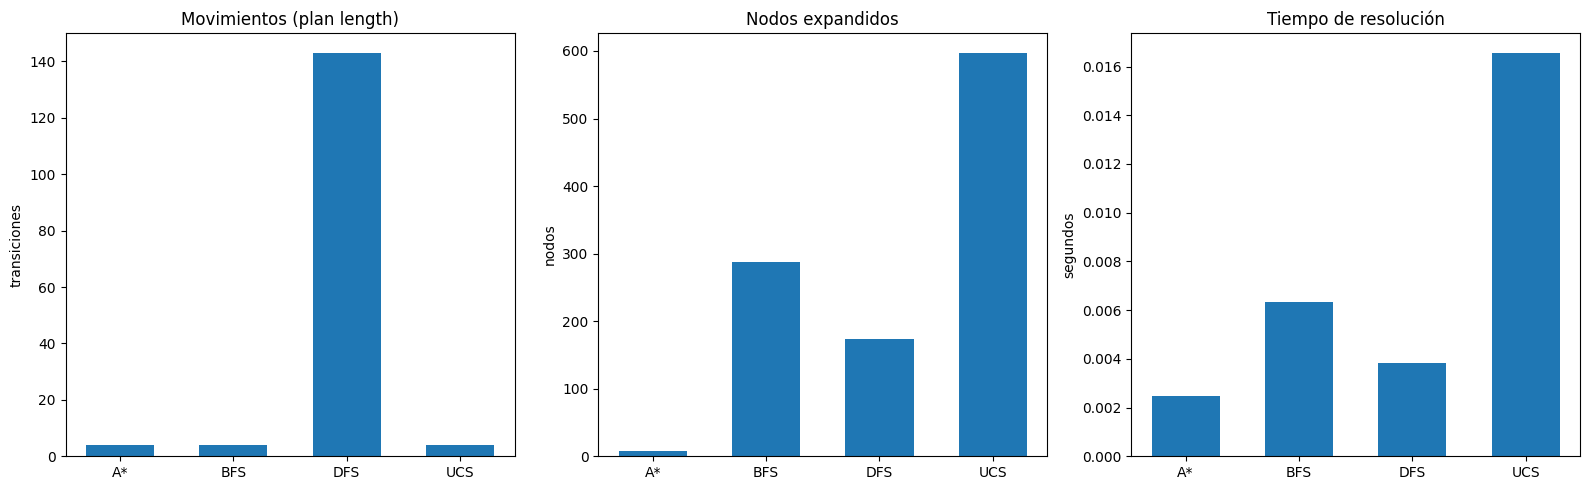

In [ ]:
# %% Cell: graficar comparativas con matplotlib
algorithms = df["algorithm"].tolist()
moves = [np.nan if pd.isna(v) else v for v in df["moves_mean"].tolist()]
expans = df["expansions_mean"].tolist()
times = df["time_mean"].tolist()

x = np.arange(len(algorithms))
width = 0.6

fig, axs = plt.subplots(1, 3, figsize=(16,5))

axs[0].bar(x, moves, width)
axs[0].set_xticks(x); axs[0].set_xticklabels(algorithms)
axs[0].set_title("Movimientos (plan length)")
axs[0].set_ylabel("transiciones")

axs[1].bar(x, expans, width)
axs[1].set_xticks(x); axs[1].set_xticklabels(algorithms)
axs[1].set_title("Nodos expandidos")
axs[1].set_ylabel("nodos")

axs[2].bar(x, times, width)
axs[2].set_xticks(x); axs[2].set_xticklabels(algorithms)
axs[2].set_title("Tiempo de resolución")
axs[2].set_ylabel("segundos")

plt.tight_layout()
plt.show()


Ejecutando experimentos para nivel difícil (8x8)...
Resultados nivel difícil (8x8):


,algorithm,moves_mean,expansions_mean,time_mean
0,A*,3,5.0,0.000995
1,BFS,3,129.0,0.003621
2,DFS,4350,4354.0,0.233691
3,UCS,3,1102.0,0.054272


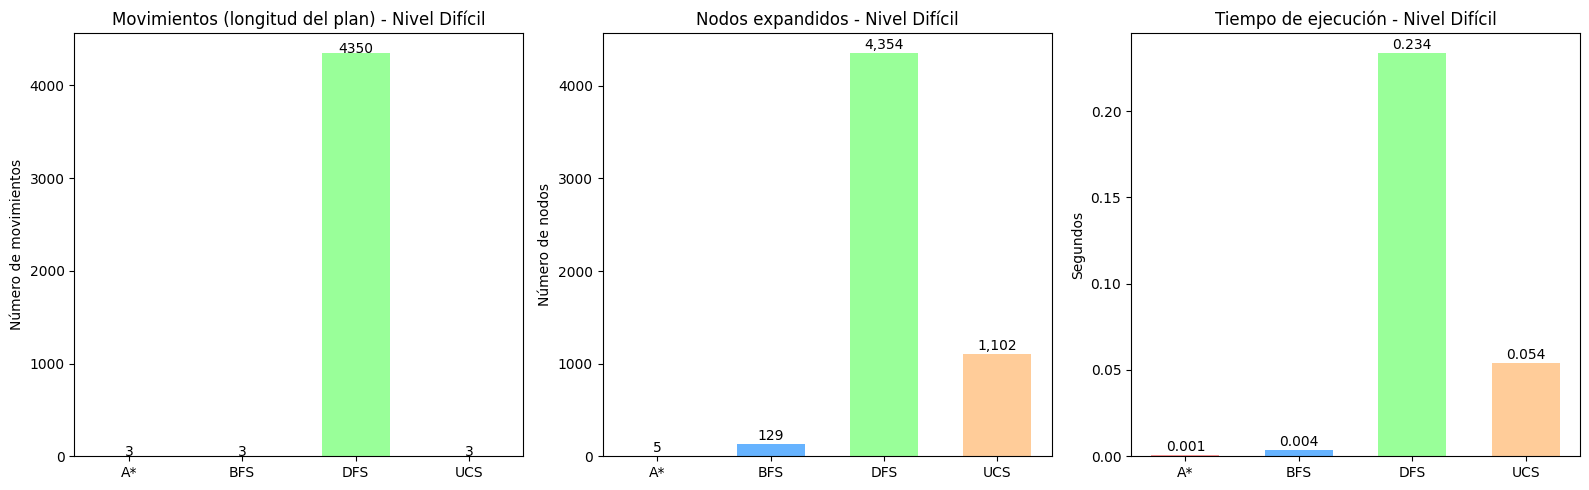

Análisis detallado - Nivel Difícil (8x8)

A*:
  - Movimientos requeridos: 3
  - Nodos expandidos: 5
  - Tiempo de ejecución: 0.0010 segundos
  - Eficiencia: 5,025 nodos/segundo

BFS:
  - Movimientos requeridos: 3
  - Nodos expandidos: 129
  - Tiempo de ejecución: 0.0036 segundos
  - Eficiencia: 35,623 nodos/segundo

DFS:
  - Movimientos requeridos: 4350
  - Nodos expandidos: 4,354
  - Tiempo de ejecución: 0.2337 segundos
  - Eficiencia: 18,631 nodos/segundo

UCS:
  - Movimientos requeridos: 3
  - Nodos expandidos: 1,102
  - Tiempo de ejecución: 0.0543 segundos
  - Eficiencia: 20,305 nodos/segundo


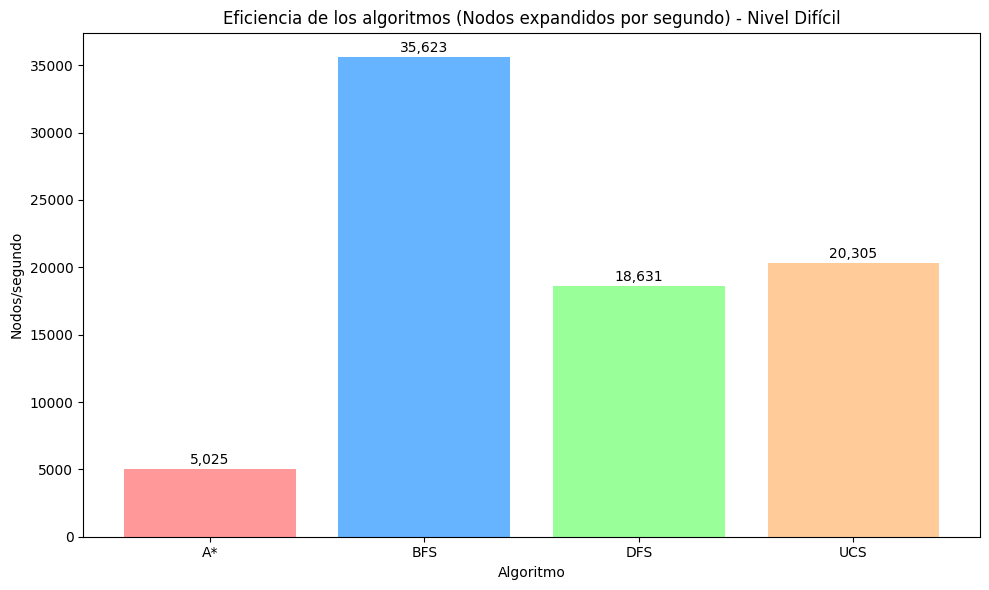

In [ ]:
# %% [markdown]
# # Análisis del Nivel Difícil (8x8) de Unblock Me
#
# Este análisis se enfoca exclusivamente en el nivel difícil (8x8) y compara el rendimiento de los algoritmos A*, BFS, DFS y UCS.

# %% [code]
# Configuración específica para el nivel difícil
ROWS, COLS = 8, 8

START_BLOCKS_HARD = [
    Block(1, 3, 2, 'H', True),   # rojo (fila 3, debe salir a la derecha)
    Block(0, 0, 3, 'V'),
    Block(2, 0, 2, 'V'),
    Block(5, 0, 3, 'V'),
    Block(7, 0, 3, 'V'),
    Block(0, 2, 3, 'H'),
    Block(3, 1, 2, 'H'),
    Block(4, 2, 2, 'V'),
    Block(6, 2, 2, 'H'),
    Block(2, 4, 3, 'H'),
    Block(0, 5, 2, 'H'),
    Block(3, 5, 3, 'V'),
    Block(5, 5, 3, 'H'),
    Block(1, 6, 2, 'V'),
    Block(6, 6, 2, 'H'),
]

# Inicializar meta global con START_BLOCKS_HARD
LEVEL_META = [(b.length, b.orientation, b.is_red) for b in START_BLOCKS_HARD]
RED_IDX = 0
for i, meta in enumerate(LEVEL_META):
    if meta[2]:
        RED_IDX = i
        break

# %% [code]
# Ejecutar experimentos para el nivel difícil
print("Ejecutando experimentos para nivel difícil (8x8)...")
df_hard = run_all(start_blocks=START_BLOCKS_HARD, repeat=3)

# %% [code]
# Mostrar resultados en tabla
print("Resultados nivel difícil (8x8):")
pd.set_option("display.precision", 6)
df_display = df_hard.copy()
df_display["moves_mean"] = df_display["moves_mean"].apply(lambda x: int(x) if pd.notna(x) else "Sin solución")
display(df_display[["algorithm", "moves_mean", "expansions_mean", "time_mean"]])

# %% [code]
# Gráficos de rendimiento para el nivel difícil
algorithms = df_hard["algorithm"].tolist()
moves = [np.nan if pd.isna(v) else v for v in df_hard["moves_mean"].tolist()]
expans = df_hard["expansions_mean"].tolist()
times = df_hard["time_mean"].tolist()

x = np.arange(len(algorithms))
width = 0.6

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico de movimientos
axs[0].bar(x, moves, width, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axs[0].set_xticks(x)
axs[0].set_xticklabels(algorithms)
axs[0].set_title("Movimientos (longitud del plan) - Nivel Difícil")
axs[0].set_ylabel("Número de movimientos")
for i, v in enumerate(moves):
    if not np.isnan(v):
        axs[0].text(i, v + 0.5, str(int(v)), ha='center')

# Gráfico de nodos expandidos
axs[1].bar(x, expans, width, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axs[1].set_xticks(x)
axs[1].set_xticklabels(algorithms)
axs[1].set_title("Nodos expandidos - Nivel Difícil")
axs[1].set_ylabel("Número de nodos")
for i, v in enumerate(expans):
    axs[1].text(i, v + max(expans)*0.01, f"{v:,.0f}", ha='center')

# Gráfico de tiempo de ejecución
axs[2].bar(x, times, width, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axs[2].set_xticks(x)
axs[2].set_xticklabels(algorithms)
axs[2].set_title("Tiempo de ejecución - Nivel Difícil")
axs[2].set_ylabel("Segundos")
for i, v in enumerate(times):
    axs[2].text(i, v + max(times)*0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

# %% [code]
# Análisis detallado de los resultados
print("Análisis detallado - Nivel Difícil (8x8)")
print("=" * 50)

for _, row in df_hard.iterrows():
    alg = row['algorithm']
    moves = row['moves_mean']
    expansions = row['expansions_mean']
    time = row['time_mean']

    print(f"\n{alg}:")
    if pd.isna(moves):
        print("  - No encontró solución")
    else:
        print(f"  - Movimientos requeridos: {int(moves)}")
    print(f"  - Nodos expandidos: {expansions:,.0f}")
    print(f"  - Tiempo de ejecución: {time:.4f} segundos")

    # Calcular eficiencia (nodos por segundo)
    if time > 0:
        efficiency = expansions / time
        print(f"  - Eficiencia: {efficiency:,.0f} nodos/segundo")

# %% [code]
# Visualización adicional: comparación de eficiencia
efficiencies = []
for _, row in df_hard.iterrows():
    if row['time_mean'] > 0:
        efficiencies.append(row['expansions_mean'] / row['time_mean'])
    else:
        efficiencies.append(0)

plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, efficiencies, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Eficiencia de los algoritmos (Nodos expandidos por segundo) - Nivel Difícil')
plt.ylabel('Nodos/segundo')
plt.xlabel('Algoritmo')

# Añadir valores en las barras
for i, v in enumerate(efficiencies):
    plt.text(i, v + max(efficiencies)*0.01, f"{v:,.0f}", ha='center')

plt.tight_layout()
plt.show()